# Lythrum salicaria segmentation dataset
The original code and data is available [here](https://github.com/gchaudhuri/deeplearning-wetland-purpleloosestrife).

Gargi Chaudhuri, Niti B. Mishra. [*Detection of Aquatic Invasive Plants in Wetlands of the Upper Mississippi River from UAV Imagery Using Transfer Learning.*](https://doi.org/10.3390/rs15030734) **Remote Sensing, 15(3)** (2023)

## Class description:
- **Label: 0** (Background)
- **Label: 1** (Lythrum salicaria)

## Channel description:
- **Channel: 1** (Red - R)
- **Channel: 2** (Green - G)
- **Channel: 3** (Blue - B)

## Python requirements:
- pytorch 1.12.0
- torchvision 0.13.0
- captum 0.6.0

In [1]:
import os
import time
import warnings
from time import strftime
from functools import partial

from PIL import Image
import tifffile as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
from skimage import io as skio
from scipy.special import expit, softmax

import torch
from torch.utils.data import DataLoader
import torch.nn.functional as func

from datasets import MosaicDataset, BalancedMosaicDataset
from models import FCN_ResNet50, FCN_ResNet101, LRASPP_MobileNet
from models import DeeplabV3_MobileNet, DeeplabV3_ResNet50, Unet2D
from utils import color_codes, time_to_string, normalise

The imports can be divided into a few different groups:
- **General packages**: This group include basic python libraries (included with any distribution of python) to perform basic operations relations to files, measuring execution time or function utilities.
- **Image packages**: This dataset uses a specific type of GeoTIFF files (?). To open them we will be using image libraries focused on TIFF files.
- **Plotting tools**: matplotlib (and seaborn) is the most commonly useful visualisation tool for plotting results.
- **Scientific tools**: This larger group includes numpy (equivalent to matlab array processing), scipy (numpy extension for scientific projects) and sklearn (and its image analysis extension). These packages provide tools to manipulate data.
- **Autodifferentiable packages**: For this notebook we will be using pytorch as our tool to build and train deep learning models.
- **Tools from the repository**: To simplify our networks, some of the meaty code is stored on a relevant file including dataset implementations, models based on torchvision and other utils.

# Data preparation
The following cells focus on the creation of the initial mosaic from patches for a more robust patch extraction (if needed). In fact, we could split the mosaic in two and use one part for training and the other for testing avoiding patches.

## Mosaic composition
The original files in the github repository only contain patches from the original mosaic. Moreover, the spatial information of these patches is somehow encoded on the file names. That implies that we need to sort the files in a specific order to obtain the original mosaic. Luckily, the ordering applies to both the mask and the images.

The following cell loads all patches, reconstructs the mask and mosaic and plots them.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


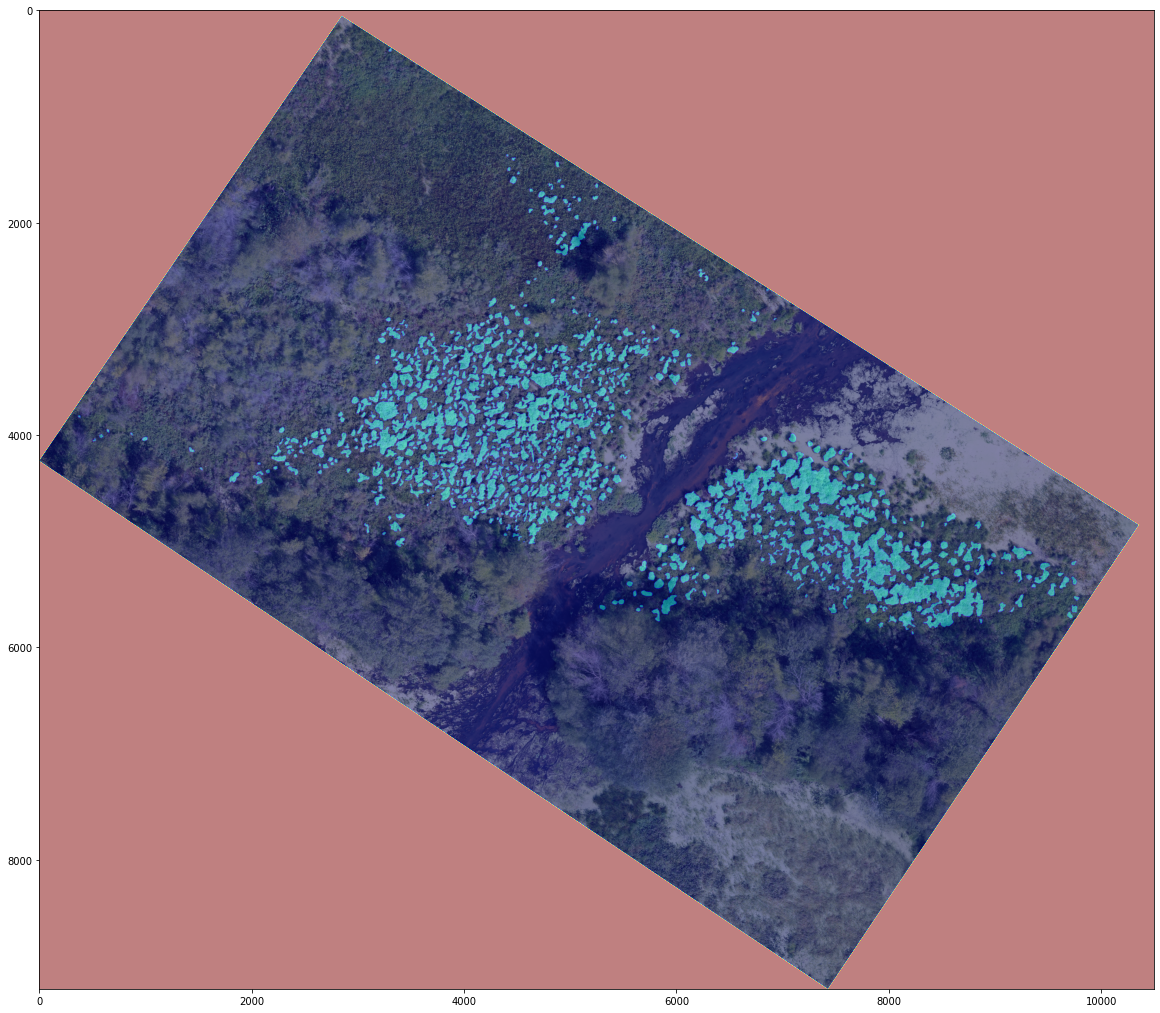

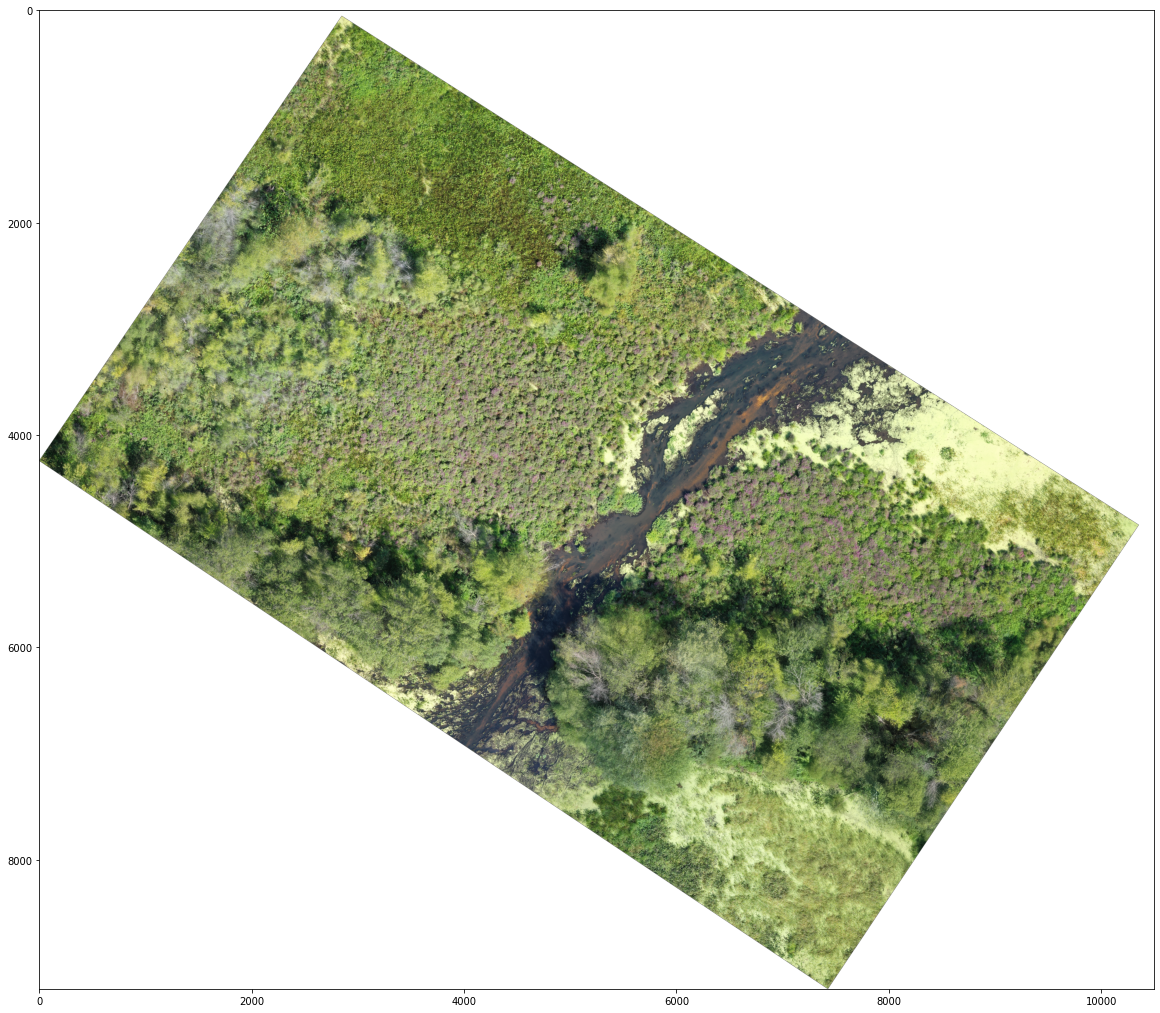

In [2]:
d_path = '/home/mariano/data/Wetlands/Chaudhuri'
path = os.path.join(d_path, 'bp_1_mask/')
impath = os.path.join(d_path, 'bp_1_img/')
maskpath = os.path.join(d_path, 'bp_1_mask/')
files = sorted(os.listdir(path))
coord_x = np.unique([
    int(f.split('.')[0].split('_')[-2])
    for f in files
])
coord_y = np.unique([
    int(f.split('.')[0].split('_')[-1])
    for f in files
])

im_cols = []
mask_cols = []
for x in coord_x:
    im_rows = []
    mask_rows = []
    for y in coord_y:
        imname = 'bp_0_{:d}_{:d}.tif'.format(x, y)
        i_path = os.path.join(impath, imname)
        im_rows.append(np.array(tf.imread(i_path)))
        maskname = 'bp_0_mask_{:d}_{:d}.tif'.format(x, y)
        m_path = os.path.join(maskpath, maskname)
        mask_rows.append(np.array(Image.open(m_path)))
    im_cols.append(np.concatenate(im_rows[::-1], axis=0))
    mask_cols.append(np.concatenate(mask_rows[::-1], axis=0))
im_mosaic = np.concatenate(im_cols, axis=1)
mask_mosaic = np.concatenate(mask_cols, axis=1)

im_y, im_x = mask_mosaic.shape

plt.figure(figsize=(im_x // 500, im_y // 500))
plt.imshow(im_mosaic / np.max(im_mosaic))
plt.imshow(mask_mosaic / 3, alpha=0.5, cmap='jet')

plt.figure(figsize=(im_x // 500, im_y // 500))
plt.imshow(im_mosaic / np.max(im_mosaic))

## Rotation
Even though we have been able to reconstruct the original mosaic, the final result contains a large amount of empty patches. This is an "artifact" of using geolocalisation to create the mosaics. Specifically, the mosaic is rotated to represent the original orientation of the covered area. However, it would be ideal to rotate that mosaic so that the amount of "empty space" is minimised. To that then, the next cell contains a function to rotate the image in 2D. 

While we are going to "manually" estimate an optimal rotation, the function is coded in pytorch and with small tweaks, the angle of rotation could be estimated leveraging the optimisation algorithms pytorch provides. Particularly, theta should be defined as a variable that requires a gradient (**requires_grad = True**) and should passed to the optimiser of choice (for example **Adam**) as a parameter. Afterwards, a loss function minimising the amount of empty space would be optimised inside a regular pytorch training loop. 

**Note:** While it might seem that the mosaic is a perfect rectangle, this is just an optical illusion as we will prove on the following cells. In that sense, the loss function cannot assume that the empty space will be fully removed!

```python
def rotate2d(image, theta)
```

This function only takes an image and angle into account and performs the rotation. We use nearest neighbor interpolation for the process, but the type of interpolation could be passed as a parameter, since we might prefer linear interpolation for the image. For our experiments it does not make a big difference.

In [3]:
def rotate2d(image, theta):
    # We assume the RGB channels are located on the last dimension.
    # For compatibility with greyscale images we still check if that dimension exists.
    if len(image.shape) == 2:
        height, width = image.shape
        image_t = np.expand_dims(image, axis=-1)
        image_tensor = torch.from_numpy(
            np.moveaxis(image_t.astype(np.float64), -1, 0)
        ).view((1, 1, height, width))
        channels = 1        
    else:
        height, width, channels = image.shape
        image_tensor = torch.from_numpy(
            np.moveaxis(image.astype(np.float64), -1, 0)
        ).view((1, channels, height, width))
    
    # Rotation definition.
    rxx = np.cos(theta)
    rxy = - np.sin(theta)
    ryx = np.sin(theta)
    ryy = np.cos(theta)
    # Translation definition.
    # For our experiments, no translation is assumed.
    # However, it could be considered as an additional parameter if needed.
    tx = 0
    ty = 0
    affine = torch.tensor(
        [
            [rxx, rxy, tx],
            [ryx, ryy, ty],
            [  0,   0,  1],
        ], dtype=torch.float64
    )

    # Image grid construction.
    # This represents the input grid we will warp with our affine
    # transformation. Technically, we are performing the inverse
    # operation. However, this theoretical subtlety is irrelevant
    # as long as we pass the "inverted angle".
    x = torch.arange(
        start=0, end=width
    ).to(dtype=torch.float64)
    norm_x = 2 * (x - width / 2) / width
    y = torch.arange(
        start=0, end=height
    ).to(dtype=torch.float64)
    norm_y = 2 * (y - height / 2) / height
    grid_x, grid_y = torch.meshgrid(norm_x, norm_y, indexing='xy')
    grid = torch.stack([
        grid_x.flatten(),
        grid_y.flatten(),
        torch.ones_like(grid_x.flatten())
    ], dim=0)
    affine_grid = affine @ grid

    # There is an additional subtlety in the code. When performing
    # a rotation we have to choose where the axis of rotation is located.
    # In general, (0, 0) represents one of the corners of the image.
    # The most common convention is the top-left corner. However,
    # rotating the image around that point would mean not just
    # rotating the mosaic but also move it around. This is not what
    # we want, so instead our (0, 0) point is defined as the center of
    # the mosaic. This is hidden from the transformation but is encoded
    # on the "normalisation" of the grid coordinates. Another option
    # would be to create an additional transformation that translates
    # the origin point to the center of the mosaic. Then we would have
    # to concatenate that transformation with our rotation.
    tensor_grid = torch.swapaxes(affine_grid[:2, :], 0, 1).view(
        1, height, width, 2
    )
    
    tensor_moved = func.grid_sample(
        image_tensor, tensor_grid,
        align_corners=True, mode='nearest'
    )

    if len(image.shape) == 2:
        moved = tensor_moved.view((height, width)).detach().numpy()
    else:
        moved = np.moveaxis(tensor_moved.view((channels, height, width)).detach().numpy(), 0, -1)        

    return moved

Having defined our rotation function, and having played with the mosaic a bit we determined that 36° is a good enough approximation. In the next cell we show tha empirically.

**Note:** We have found an optimal rotation, but we have not really solved the empty space problem. If anything it actually looks like we have created more "empty space". Once again, this is an optical illusion. Nonetheless, we still need to crop all the empty space using the red bounding box.

BB area (36.0) = 4.966675e+07


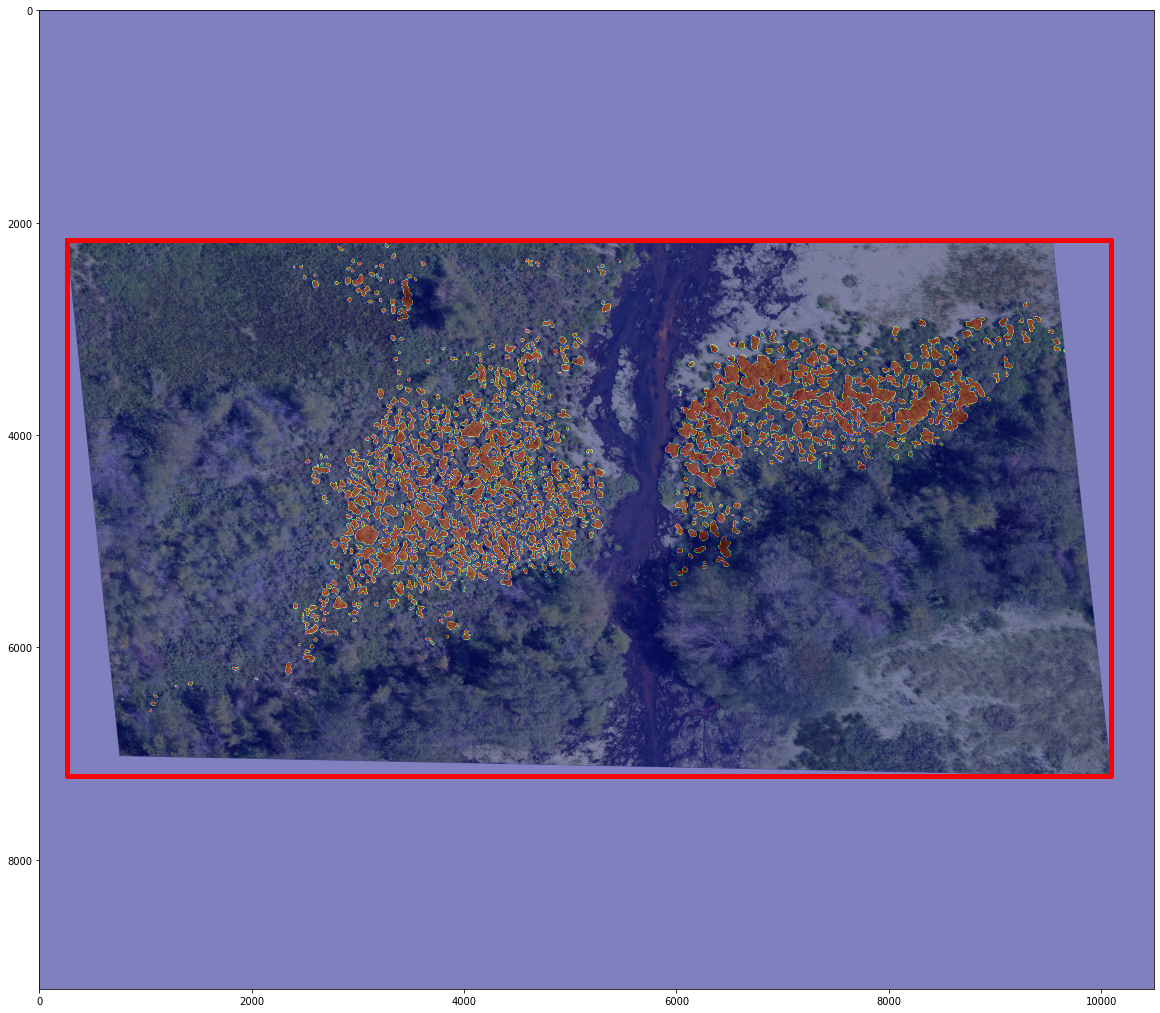

In [4]:
plt.figure(figsize=(im_x // 500, im_y // 500))

theta_d = 36
theta = np.pi * theta_d / 180
rot_mosaic = rotate2d(im_mosaic, theta)
rot_mask = rotate2d(mask_mosaic, theta)

rot_mask[rot_mosaic[..., -1] <= 0] = 3
bin_mask = rot_mask == 1
rot_mosaic[rot_mosaic <= 0] = 0
plt.imshow(rot_mosaic / np.max(rot_mosaic))
plt.imshow(bin_mask, alpha=0.5, cmap='jet')

min_bb = np.min(np.where(rot_mask < 3), axis=1)
max_bb = np.max(np.where(rot_mask < 3), axis=1)

print(
    'BB area ({:4.1f}) = {:e}'.format(
        theta_d, (max_bb[0] - min_bb[0]) * (max_bb[1] - min_bb[1])
    )
)
plt.plot(
    [min_bb[1], min_bb[1], max_bb[1], max_bb[1], min_bb[1]],
    [min_bb[0], max_bb[0], max_bb[0], min_bb[0], min_bb[0]],
    'r-', linewidth=5
)

After cropping the mask and mosaic, the last step is to now split the image into training and testing. For our experiments we manually chose the line that splits the two largest sets of plants. This is arbitrary, but it is the best "independent" partition we can make.

(5051, 9836, 4)


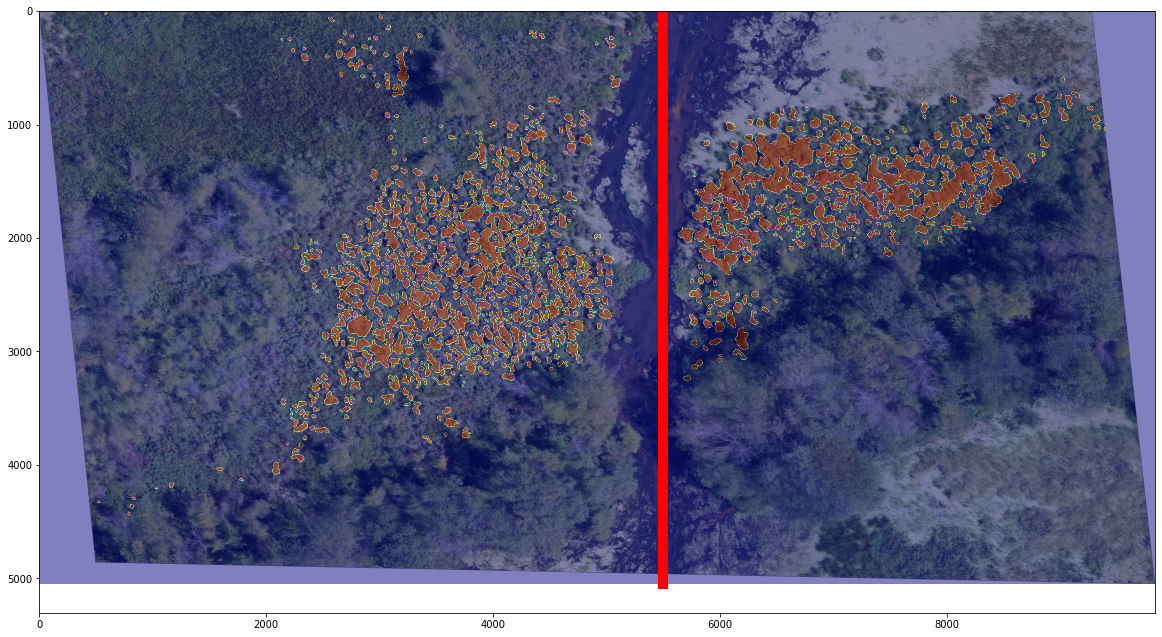

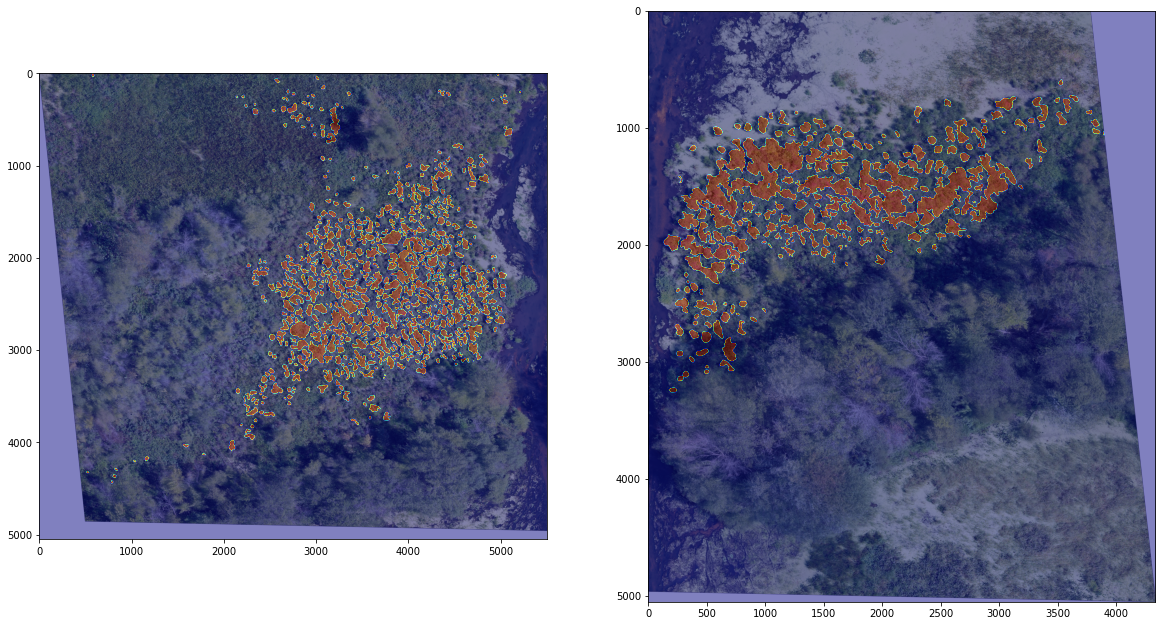

In [5]:
cropped_mask = bin_mask[min_bb[0]:max_bb[0] + 1, min_bb[1]:max_bb[1] + 1]
cropped_mosaic = rot_mosaic[min_bb[0]:max_bb[0] + 1, min_bb[1]:max_bb[1] + 1, :]

plt.figure(figsize=(im_x // 500, im_y // 500))
plt.imshow(cropped_mosaic / np.max(cropped_mosaic))
plt.imshow(cropped_mask, alpha=0.5, cmap='jet')
plt.plot(
    [5500, 5500],
    [0, cropped_mosaic.shape[0]],
    'r-', linewidth=10
)
print(cropped_mosaic.shape)
training_mosaic = cropped_mosaic[:, :5500]
training_mask = cropped_mask[:, :5500]

testing_mosaic = cropped_mosaic[:, 5500:]
testing_mask = cropped_mask[:, 5500:]

plt.figure(figsize=(im_x // 500, im_y // 500))
plt.subplot(1, 2, 1)
plt.imshow(training_mosaic / np.max(cropped_mosaic))
plt.imshow(training_mask, alpha=0.5, cmap='jet')
plt.subplot(1, 2, 2)
plt.imshow(testing_mosaic / np.max(cropped_mosaic))
plt.imshow(testing_mask, alpha=0.5, cmap='jet')

# Main function
The following cell contains the main function that will be used to run all the experiments for the dataset.

```python
def run_segmentation_experiments(
    master_seed, network_name, display_name, experiment_name, network_f, training_data, testing_data,
    weight_path, maps_path, classes=None, patch_size=256, overlap=128, epochs=10, patience=5,
    n_seeds=30, n_inputs=3, n_classes=2, train_batch=20, test_batch=50, saliency_batch=4, verbose=1
)
```

This is the main function involved in the experimentation process. To allow for multiple *random* runs, the function requires a **master_seed** (that defines the seed that will used to determine the seeds for each random run). Furthermore, a **network_name** is required for the weights file while a **display_name** is required to display debugging messages regarding the required *function* to instantiate the **network** that will be trained. The **classes** variable with a list of the class names and the **experiment_name** variables are also used to display messages regarding the results and experiment type.

For training and testing, a tuple of lists containing the mosaics and masks are required as **training_data** and **testing_data** for training and testing, respectively; and the **weight_path** and **maps_path** where the model weights and salienc maps will be stored. The other parameters relate to the network hyperparameters and training / optimisation parameters and are optional.

In [6]:
def run_segmentation_experiments(
    master_seed, network_name, display_name, experiment_name, network_f, training_data, testing_data,
    weight_path, maps_path, classes=None, patch_size=256, overlap=128, epochs=10, patience=5,
    n_seeds=30, n_inputs=3, n_classes=2, train_batch=20, test_batch=50, saliency_batch=4, verbose=1
):
    # Init
    training_mosaics, training_masks = training_data
    testing_mosaics, testing_masks = testing_data
    
    # While we use a BalancedLythrumDataset for training, it might
    # be a good idea to also use LythrumDataset. The choice of dataset
    # should be coherent with what we do on the other datasets.  
    training_set = BalancedMosaicDataset(
        training_mosaics, training_masks, patch_size, overlap
    )
    validation_set = MosaicDataset(
        training_mosaics, training_masks, patch_size, overlap
    )
    
    # Choosing random runs.
    np.random.seed(master_seed)
    seeds = np.random.randint(0, 100000, n_seeds)
    c = color_codes()

    dsc_list = []
    class_dsc_list = []
    # Main loop to run each independent random experiment.
    for test_n, seed in enumerate(seeds):
        acc = 0
        np.random.seed(seed)
        torch.manual_seed(seed)
        
        # The network will only be instantiated with the number of output classes
        # (2 in this notebok). Therefore, networks that need extra parameters (like ViT)
        # will need to be passed as a partial function.
        net = network_f(n_inputs=n_inputs, n_outputs=n_classes)
               
        # This is a leftover from legacy code. If init is set to True (the default option),
        # a first validation epoch will be run to determine the loss before training.
        net.init = False
        
        # The number of parameters is only captured for debugging and printing.
        n_param = sum(
            p.numel() for p in net.parameters() if p.requires_grad
        )

        if verbose > 1:
            print(
                '{:}[{:}] {:}Starting experiment {:}(seed {:05d} - {:} {:}[{:,} parameters]{:})'
                '{:} [{:02d}/{:02d}] {:}for {:} segmentation{:}'.format(
                    c['clr'] + c['c'], strftime("%m/%d/%Y - %H:%M:%S"), c['g'],
                    c['nc'] + c['y'], seed, c['b'] + display_name,
                    c['nc'], n_param, c['y'],
                    c['nc'] + c['c'], test_n + 1, len(seeds),
                    c['nc'] + c['g'], c['b'] + experiment_name + c['nc'] + c['g'], c['nc']
                )
            )
        
        training_loader = DataLoader(
            training_set, train_batch, True
        )
        validation_loader = DataLoader(
            validation_set, test_batch
        )
        model_path = os.path.join(
            weight_path, '{:}-balanced_s{:05d}_p{:03d}.pt'.format(network_name, seed, patch_size)
        )
        
        # For efficiency, we only run the code once. If the weights are
        # stored on disk, we do not need to train again.
        try:
            net.load_model(model_path)
        except IOError:
            net.train()
            print(''.join([' '] * 200), end='\r')
            net.fit(training_loader, validation_loader, epochs=epochs, patience=patience)
            net.save_model(model_path)
        
        if verbose > 2:
            print(''.join([' '] * 200), end='\r')
            print(
                '{:}[{:}] {:}Testing {:}(seed {:05d}){:} [{:02d}/{:02d}] '
                '{:}for {:} segmentation <{:03d} samples>{:}'.format(
                    c['clr'] + c['c'], strftime("%m/%d/%Y - %H:%M:%S"), c['g'],
                    c['nc'] + c['y'], seed, c['nc'] + c['c'], test_n + 1, len(seeds),
                    c['nc'] + c['g'], c['b'] + experiment_name + c['nc'] + c['g'], 
                    len(training_set), c['nc']
                )
            )
        
        # Metric evaluation.
        net.eval()
        with torch.no_grad():
            mosaic_dsc = []
            mosaic_class_dsc = []
            # Intermediate buffers for class metrics.
            for input_mosaic, mask_i in zip(testing_mosaics, testing_masks):
                pred_map = net.patch_inference(
                    normalise(input_mosaic).astype(np.float32),
                    patch_size, test_batch
                )
            
                pred_y = np.argmax(pred_map, axis=0).astype(np.uint8)
                y = mask_i.astype(np.uint8)
                intersection = np.stack([
                    2 * np.sum(np.logical_and(pred_y == lab, y == lab))
                    for lab in range(n_classes)
                ])
                card_pred_y = np.stack([
                    np.sum(pred_y == lab) for lab in range(n_classes)
                ])
                card_y = np.stack([
                    np.sum(y == lab) for lab in range(n_classes)
                ])
                dsc_k = intersection / (card_pred_y + card_y)
                dsc = np.nanmean(dsc_k)
                mosaic_dsc.append(dsc)
                mosaic_class_dsc.append(dsc_k.tolist())

                for i, map_i in enumerate(softmax(pred_map, axis=0)):
                    map_path = os.path.join(
                        maps_path, '{:}-balanced_s{:05d}_map_{:02d}.png'.format(
                            network_name, seed, i
                        )
                    )
                    final_map = (255 * map_i).astype(np.uint8)
                    skio.imsave(map_path, final_map.astype(np.uint8))
                map_path = os.path.join(
                    maps_path, '{:}-balanced_s{:05d}_masks.png'.format(
                        network_name, seed
                    )
                )
                final_map = (255 * (pred_y / (n_classes - 1))).astype(np.uint8)
                skio.imsave(map_path, final_map.astype(np.uint8))
                
                dsc = np.nanmean(mosaic_dsc, axis=0)
                class_dsc = np.nanmean(mosaic_class_dsc, axis=0)
        if verbose > 2:
            print(''.join([' '] * 200), end='\r')
            print(
                '{:}[{:}] {:}DSC{:} (seed {:05d}){:} [{:02d}/{:02d}] {:}'
                '{:5.3f}{:}'.format(
                    c['clr'] + c['c'], strftime("%m/%d/%Y - %H:%M:%S"), c['g'],
                    c['nc'] + c['y'], seed, c['nc'] + c['c'], test_n + 1, len(seeds),
                    c['nc'] + c['b'], dsc, c['nc']
                )
            )

            class_dsc_s = ', '.join([
            '{:} {:5.3f}'.format(k, dsc_k)
                for k, dsc_k in zip(classes, class_dsc)
            ])
            print(
                '{:}[{:}] {:}Class DSC{:} (seed {:05d}){:} [{:02d}/{:02d}] {:}'.format(
                    c['clr'] + c['c'], strftime("%m/%d/%Y - %H:%M:%S"), c['g'],
                    c['nc'] + c['y'], seed, c['nc'] + c['c'], test_n + 1, len(seeds),
                    c['nc'] + c['b'] + class_dsc_s + c['nc']
                )
            )
        elif verbose > 1:
            print(''.join([' '] * 200), end='\r')
            print(
                '{:}Seed {:05d} {:} [{:,} parameters] '
                '{:}[{:02d}/{:02d}] {:} {:5.3f}{:}'.format(
                    c['y'], seed, c['b'] + display_name + c['nc'], n_param,
                    c['c'], test_n + 1, len(seeds),
                    c['nc'] + c['g'] + c['b'] + experiment_name + c['nc'] + c['b'],
                    dsc, c['nc']
                )
            )
        elif verbose > 0:
            print(''.join([' '] * 200), end='\r')
            print(
                '{:}Seed {:05d} {:} [{:,} parameters] '
                '{:}[{:02d}/{:02d}] {:} {:5.3f}{:}'.format(
                    c['y'], seed, c['b'] + display_name + c['nc'], n_param,
                    c['c'], test_n + 1, len(seeds),
                    c['nc'] + c['g'] + c['b'] + experiment_name + c['nc'] + c['b'],
                    dsc, c['nc']
                ), end='\r'
            )
        net = None
        torch.cuda.empty_cache()
        torch.cuda.ipc_collect()
        dsc_list.append(mosaic_dsc)
        class_dsc_list.append(mosaic_class_dsc)
    
    # Metrics for all the runs.
    if verbose > 0:
        print(''.join([' '] * 200), end='\r')
        print(
            '{:}[{:}] {:} Mean DSC{:} {:5.3f}{:}'.format(
                c['clr'] + c['c'], strftime("%m/%d/%Y - %H:%M:%S"),
                c['nc'] + c['y'] + c['b'] + display_name + c['nc'] + c['g'],
                c['nc'] + c['b'], np.nanmean(dsc_list), c['nc']
            )
        )
        class_dsc_s = ', '.join([
            '{:} {:5.3f}'.format(k, dsc_k)
            for k, dsc_k in zip(
                classes, np.nanmean(class_dsc_list, axis=(0, 1))
            )
        ])
        print(
            '{:}[{:}] {:} Mean class DSC {:}'.format(
                c['clr'] + c['c'], strftime("%m/%d/%Y - %H:%M:%S"), 
                c['nc'] + c['y'] + c['b'] + display_name + c['nc'] + c['g'],
                c['nc'] + c['b'] + class_dsc_s + c['nc']
            )
        )
        
    return dsc_list, class_dsc_list

In [ ]:
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

master_seed = 42

train_batch = 32
test_batch = 64
patch_size = 128
overlap = 16
epochs = 50
patience = 50
name = 'lythrum'
classes = [
    'Background', 'Lythrum salicaria'
]

image_path = os.path.join(
    d_path, 'Predictions', 'testing_image.png'
)
skio.imsave(image_path, testing_mosaic.astype(np.uint8))
mask_path = os.path.join(
    d_path, 'Predictions', 'testing_mask.png'
)
skio.imsave(mask_path, (255 * testing_mask).astype(np.uint8))

training_set = (
    [np.moveaxis(training_mosaic[..., :3], -1, 0)],
    [training_mask.astype(np.uint8)]
)
testing_set = (
    [np.moveaxis(testing_mosaic, -1, 0)],
    [testing_mask.astype(np.uint8)]
)

# The experiments are run next. We capture some warnings related to
# image loading to clean the debugging console.
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    
    # Unet [64, 64, 256, 256, 512, 512]
    unet_dsc, unet_k_dsc = run_segmentation_experiments(
        master_seed, 'unet2d', 'Unet 2D', name,
        partial(Unet2D, lr=1e-4, conv_filters=[64, 64, 256, 256, 512, 512]),
        training_set, testing_set,
        os.path.join(d_path, 'Weights'), os.path.join(d_path, 'Predictions'),
        classes, n_inputs=3, n_classes=2, epochs=epochs, patience=patience,
        train_batch=train_batch, test_batch=test_batch,
        patch_size=patch_size, overlap=overlap, verbose=1
    )
    
    # FCN ResNet50
    fcn50_dsc, fcn50_k_dsc = run_segmentation_experiments(
        master_seed, 'fcn-resnet50', 'FCN ResNet50', name,
        partial(FCN_ResNet50, lr=1e-4, pretrained=True),
        training_set, testing_set,
        os.path.join(d_path, 'Weights'), os.path.join(d_path, 'Predictions'),
        classes, n_inputs=3, n_classes=2, epochs=epochs, patience=patience,
        train_batch=train_batch, test_batch=test_batch,
        patch_size=patch_size, overlap=overlap, verbose=1
    )
    
    # FCN ResNet101
    fcn101_dsc, fcn101_k_dsc = run_segmentation_experiments(
        master_seed, 'fcn-resnet101', 'FCN ResNet101', name,
        partial(FCN_ResNet101, lr=1e-4, pretrained=True),
        training_set, testing_set,
        os.path.join(d_path, 'Weights'), os.path.join(d_path, 'Predictions'),
        classes, n_inputs=3, n_classes=2, epochs=epochs, patience=patience,
        train_batch=train_batch, test_batch=test_batch,
        patch_size=patch_size, overlap=overlap, verbose=1
    )

    # DeeplapV3 MobileNet
    dl3mn_dsc, dl3mn_k_dsc = run_segmentation_experiments(
        master_seed, 'deeplab3-mobilenet', 'DeeplabV3 MobileNet', name,
        partial(DeeplabV3_MobileNet, lr=1e-4, pretrained=True),
        training_set, testing_set,
        os.path.join(d_path, 'Weights'), os.path.join(d_path, 'Predictions'),
        classes, n_inputs=3, n_classes=2, epochs=epochs, patience=patience,
        train_batch=train_batch, test_batch=test_batch,
        patch_size=patch_size, overlap=overlap, verbose=1
    )

    # DeeplapV3 ResNet50
    dl3rn_dsc, dl3rn_k_dsc = run_segmentation_experiments(
        master_seed, 'deeplab3-resnet50', 'DeeplabV3 ResNet50', name,
        partial(DeeplabV3_ResNet50, lr=1e-4, pretrained=True),
        training_set, testing_set,
        os.path.join(d_path, 'Weights'), os.path.join(d_path, 'Predictions'),
        classes, n_inputs=3, n_classes=2, epochs=epochs, patience=patience,
        train_batch=train_batch, test_batch=test_batch,
        patch_size=patch_size, overlap=overlap, verbose=1
    )

    # L-RASPP ResNet50
    lraspp_dsc, lraspp_k_dsc = run_segmentation_experiments(
        master_seed, 'lraspp-mobilenet', 'Lite R-ASPP MobileNet', name,
        partial(LRASPP_MobileNet, lr=1e-4, pretrained=True),
        training_set, testing_set,
        os.path.join(d_path, 'Weights'), os.path.join(d_path, 'Predictions'),
        classes, n_inputs=3, n_classes=2, epochs=epochs, patience=patience,
        train_batch=train_batch, test_batch=test_batch,
        patch_size=patch_size, overlap=overlap, verbose=1
    )

           Epoch num |  train  |   val   |   xent   |   dsc    |   mIoU   |  drp  |
           ----------|---------|---------|----------|----------|----------|-------|
           Epoch 000 |  0.3736 |  0.7534 |   0.2366 |   0.5167 |   0.5532 | 0.000 | 12s                                                                                                                                                                                                                                                                                                                                                                                                                                                                       
